In [1]:
import sys
sys.path.append('..')

In [2]:
import tensorflow as tf
from tensorflow import keras

import config
from losses import MSE
from models import unet
from capsa import EnsembleWrapper

from utils import (
    notebook_select_gpu,
    load_depth_data,
    load_apollo_data,
    get_normalized_ds,
    visualize_depth_map,
    plot_loss,
    gen_ood_comparison,
    gen_calibration_plot,
)

notebook_select_gpu(0)

## Train model

In [3]:
(x_train, y_train), (x_test, y_test) = load_depth_data()

ds_train = get_normalized_ds(x_train[: config.N_TRAIN], y_train[: config.N_TRAIN])
ds_test = get_normalized_ds(x_test[: config.N_TEST], y_test[: config.N_TEST])

_, (x_ood, y_ood) = load_apollo_data()
ds_ood = get_normalized_ds(x_ood, y_ood)

2022-12-08 17:43:59.782528: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.
2022-12-08 17:44:00.186612: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.


In [4]:
model_name = "ensemble"

base_model = unet()
model = EnsembleWrapper(base_model, num_members=4)
model.compile(
    optimizer=[keras.optimizers.Adam(learning_rate=config.LR)],
    loss=[MSE],
)

In [5]:
history = model.fit(
    ds_train,
    epochs=config.EP,
    validation_data=ds_test,
)

2022-12-08 09:46:30.541592: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.


Epoch 1/20


2022-12-08 09:46:33.829719: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-08 09:46:33.830150: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-12-08 09:46:34.971543: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-08 09:46:35.031224: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more

64/64 [==============================] - 36s 469ms/step - usermodel_0_loss: 0.1216 - usermodel_1_loss: 0.1639 - usermodel_2_loss: 0.1406 - usermodel_3_loss: 0.1783 - average_loss: 0.1511 - val_usermodel_0_loss: 0.0741 - val_usermodel_1_loss: 0.0969 - val_usermodel_2_loss: 0.0890 - val_usermodel_3_loss: 0.1052
Epoch 2/20
64/64 [==============================] - 30s 463ms/step - usermodel_0_loss: 0.0650 - usermodel_1_loss: 0.0813 - usermodel_2_loss: 0.0767 - usermodel_3_loss: 0.0875 - average_loss: 0.0776 - val_usermodel_0_loss: 0.0566 - val_usermodel_1_loss: 0.0686 - val_usermodel_2_loss: 0.0659 - val_usermodel_3_loss: 0.0727
Epoch 3/20
64/64 [==============================] - 30s 464ms/step - usermodel_0_loss: 0.0517 - usermodel_1_loss: 0.0614 - usermodel_2_loss: 0.0594 - usermodel_3_loss: 0.0647 - average_loss: 0.0593 - val_usermodel_0_loss: 0.0471 - val_usermodel_1_loss: 0.0542 - val_usermodel_2_loss: 0.0529 - val_usermodel_3_loss: 0.0573
Epoch 4/20
64/64 [===========================

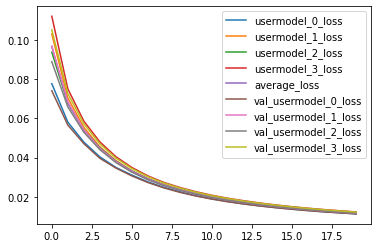

In [7]:
plot_loss(history)

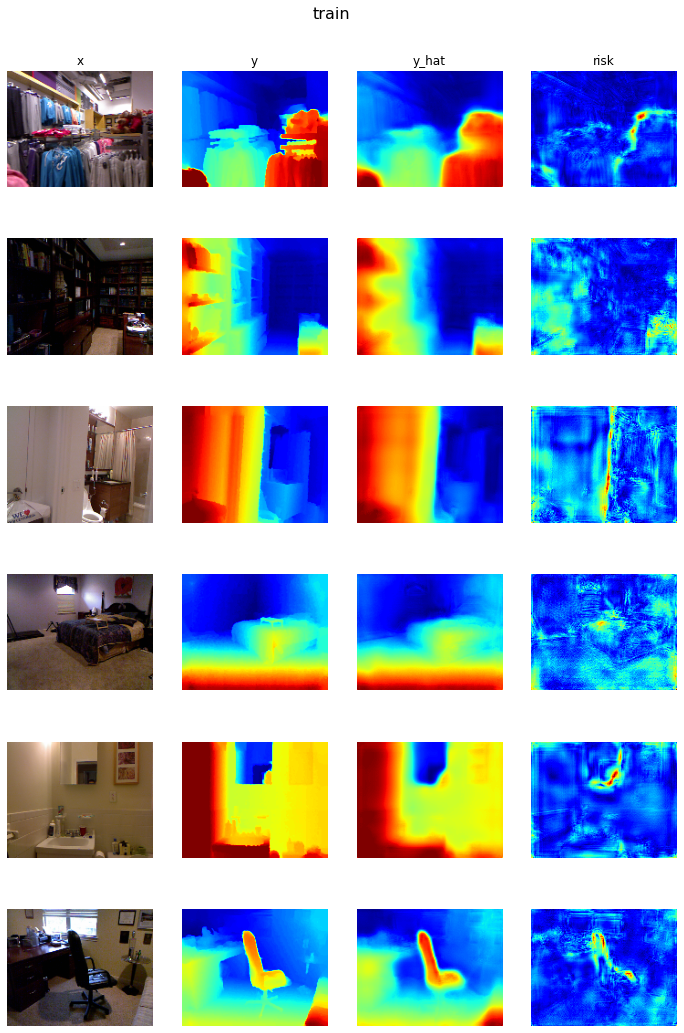

In [8]:
visualize_depth_map(model, ds_train, "train")

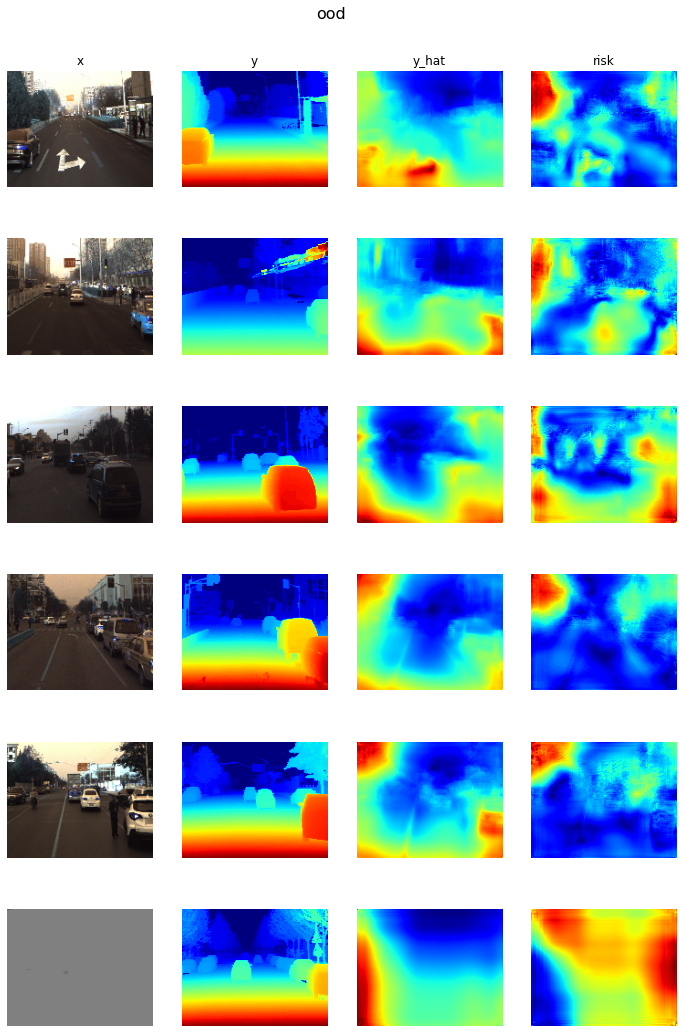

In [9]:
visualize_depth_map(model, ds_ood, "ood")

## Load trained model

In [4]:
from utils import load_model, select_best_checkpoint

opts = {'num_members':4}
path, model_name = select_best_checkpoint('/home/iaroslavelistratov/results/ensemble/20221208-214907-4_members')
trained_model = load_model(path, model_name, ds_train, opts, quite=False)

2022-12-08 17:45:03.322793: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 503316480 exceeds 10% of free system memory.
2022-12-08 17:45:06.628090: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-08 17:45:06.628915: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-12-08 17:45:07.855572: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-08 17:45:08.015877: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.

Successfully loaded weights from /home/iaroslavelistratov/results/ensemble/20221208-214907-4_members/checkpoints/0.002477vloss_35972iter.tf.


/home/iaroslavelistratov/depth/capsa/experiments/notebooks/../utils.py:61: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad(color="black")


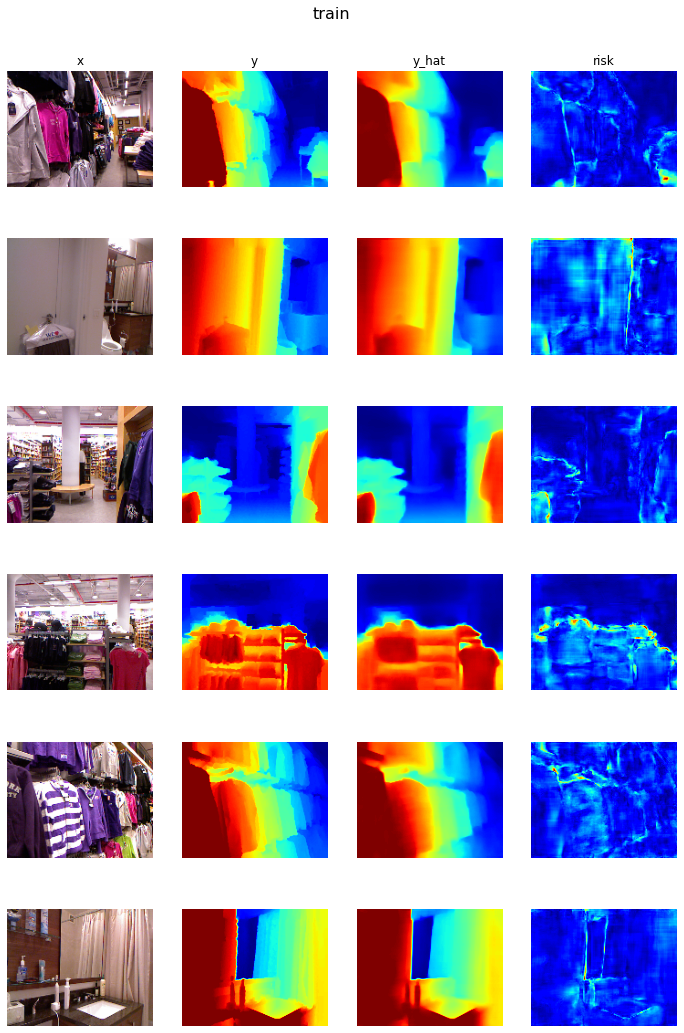

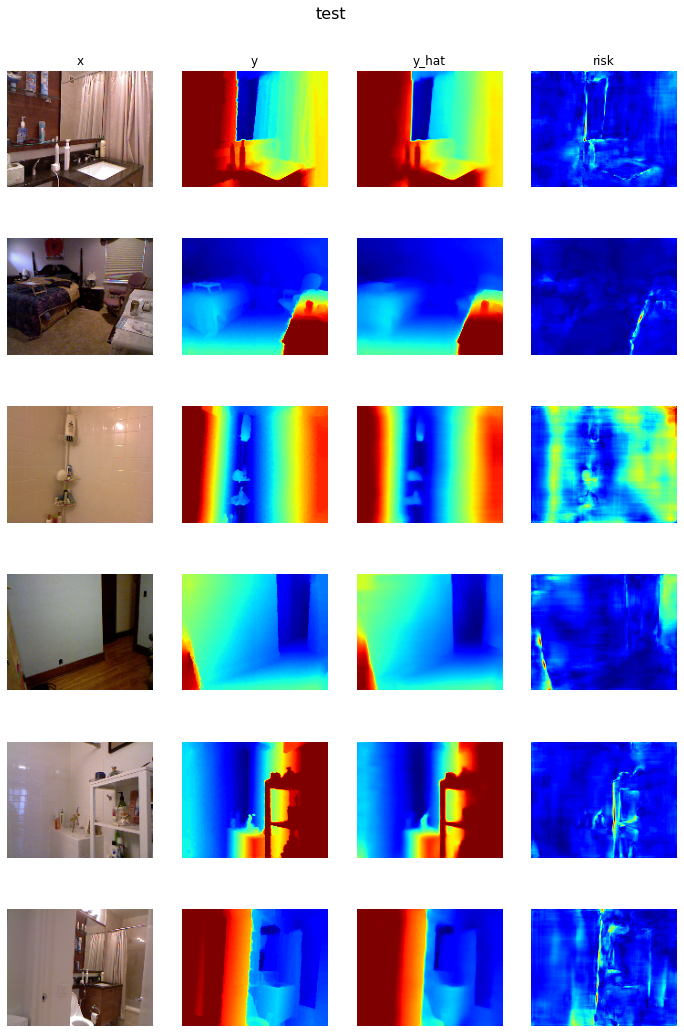

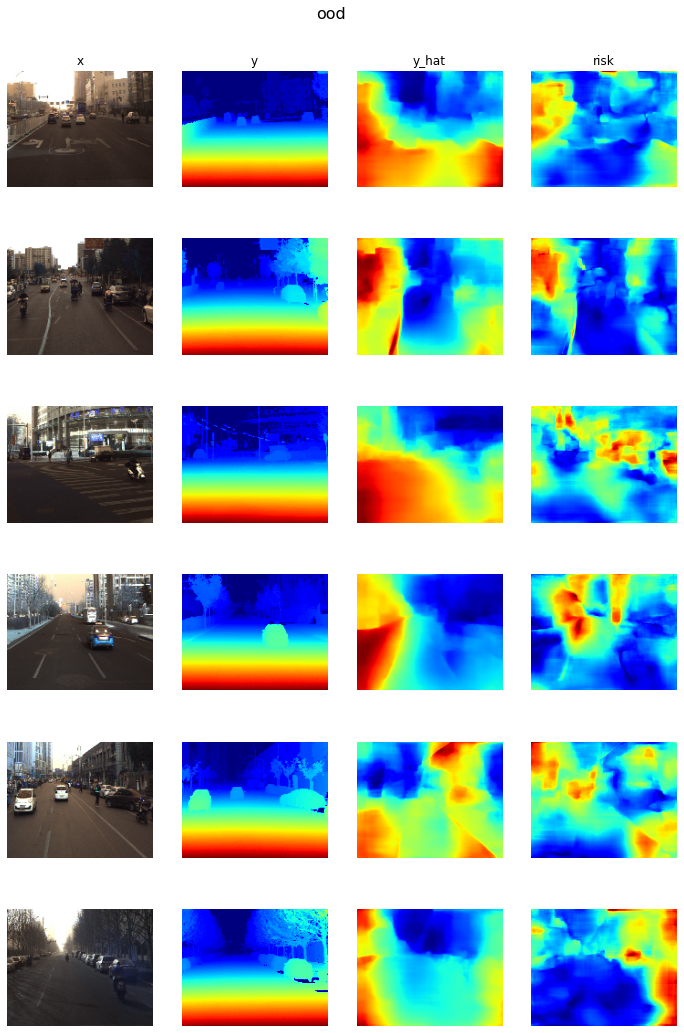

In [6]:
visualize_depth_map(trained_model, ds_train, "train")
visualize_depth_map(trained_model, ds_test, "test")
visualize_depth_map(trained_model, ds_ood, "ood")

## Calibration curve

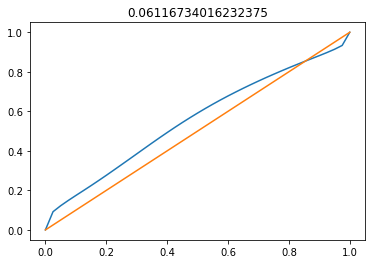

In [7]:
from utils import gen_calibration_plot
gen_calibration_plot(trained_model, ds_test)

## OOD plot

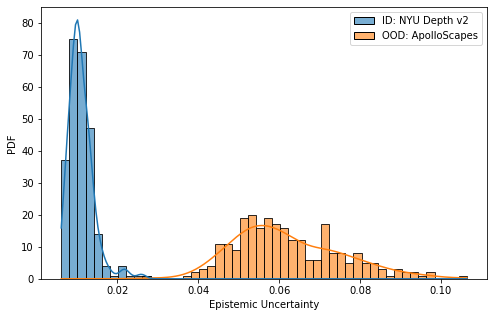

In [8]:
from utils import gen_ood_comparison
ensemble_iid, ensemble_ood = gen_ood_comparison(ds_test, ds_ood, trained_model, reduce='per_img', is_show=True, is_return=True)